<H1> A ski resort's daily traffic <H1>

<H2> Introduction <H2>

<p>
As a significant portion of the country's tourism and recreation sectors, french ski resorts generate billions dollars of annual revenues.
Recreation, lodging, food services, retail, and other sectors are directly affected by the traffic brought to the resort. 
The number of people using the 'domain' (ski and chairlifts) is thus a pretty good estimator of the overall revenues generated throughout the resort.

We can define two types of traffic:
- the skiers spending one or two skiing days in the resort (short stay)
- the skiers spending a skiing week (long stay)

Both will be included in our daily traffic analysis.
<p>

<H2> Problem <H2>

The business model of a ski resort is the following: each skier is given a daily skipass for a fixed fee, giving him all access to several lifts in the resort.
Daily revenues are directly correlated with different factors that can significantly affect the traffic.
Amongst them are some quite well identified (e.g. day of the week, holidays), and other ones that are harder to predict (weather and snow conditions).

Revenues being very different from one day to another, operating costs however stay fixed.
My goal is to assist managers of a given ski-resort in:
- understanding which factors account for the most skiers traffic
- better estimating their daily traffic

In fine, a sharper knowledge daily traffic leads to changes in revenues/costs monitoring.<br>
e.g.:
- price adjustment strategies (dynamic and segmented pricing)
- cost adjustment strategies (dynamic allocation of ressources: here lifts and employees)

<H2> The Data <H2>

3 sources of data have been aggregated:

1. Resort daily traffic
Gracefully provided by the given ski resort.
Also indicates specifics about the different lifts (location, type, length, skiers debit).
Dates: from 2007 to 2016, January 1st to March 31st.

2. Weather data
Weather platform Meteofrance gives access to daily data for all french ski-resorts, from temperature to snowfalls.
Dates: from 2011 to 2016, January 1st to March 31st.

3. Additional Weather data
Avalanches.net helped me finding missing data (2006 to 2011), and cross-validating my weather data with other sources (from tourist bureaus).


The final dataset contains 
- 1 row per date from January 1st, 2006 to March 31st, 2016.
- N columns, N-1 being potential predictors of the daily traffic, and one being the traffic.




<H2> Methods and models <H2>

I opted for a multiple linear regression model to predict the daily traffic, for several reasons:
- it applies to predicting a continuous variable. 
We are willing here to approximate a precise number (daily traffic), that can take an infinite number of possible values.

- it uses 'supervised' machine learning. <br>
Meaning that I already know the answer, and that I will manually refine my data and model to get better estimations over time.
<br>It also implies that I will get a better understanding on how much impact the different predictors (variables such as 'daily weather' or 'day of the week') will have in the observed daily traffic.<br>

I'll use Ordinary Least Square (OLS) technique, that tries to reduce the sum of squared errors by finding the best possible value of regression coefficients.<br>


On average, 67K skiers enjoy the slopes of the resort per day.<br>
Taking the mean is the most intuitive and simple approximation of daily traffic, known as the "baseline accuracy".<br>
Hopefully our model will do better than that!

<H2> Risks & assumptions <H2>



The main risks I see are the following:

- scarcity of observations (997 dates) leading to a non-significantly trained model
- incapacity of retrieving all weather data
- inconsistency of the measurements (weather, and traffic)
- unability to find a fulfilling predictor

<H2> Exploring Data <H2> 

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import pprint
from datetime import time, datetime as dt, timedelta

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display
from unidecode import unidecode

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [127]:
df = pd.read_csv('../data/interim/entries_per_date_20170125.csv')
del df['Unnamed: 0']

In [128]:
df.head()

,date,entries,season_year,season_month,day_of_week
0,2007-01-01,47532,2007,1,Monday
1,2007-01-02,73774,2007,1,Tuesday
2,2007-01-03,47495,2007,1,Wednesday
3,2007-01-04,73821,2007,1,Thursday
4,2007-01-05,59757,2007,1,Friday


In [129]:
entries_per_year = df.groupby(['season_year'])[['entries']].sum().reset_index()

In [130]:
entries_per_year

,season_year,entries
0,2007,4335015
1,2008,6205161
2,2009,6557197
3,2010,6223395
4,2011,5507292
5,2012,6704873
6,2013,7100166
7,2014,6593800
8,2015,6282215
9,2016,6412084


In [268]:
entries_per_year.sort_values('entries', ascending = False)

,season_year,entries
6,2013,7100166
5,2012,6704873
7,2014,6593800
2,2009,6557197
9,2016,6412084
8,2015,6282215
3,2010,6223395
1,2008,6205161
4,2011,5507292
0,2007,4335015


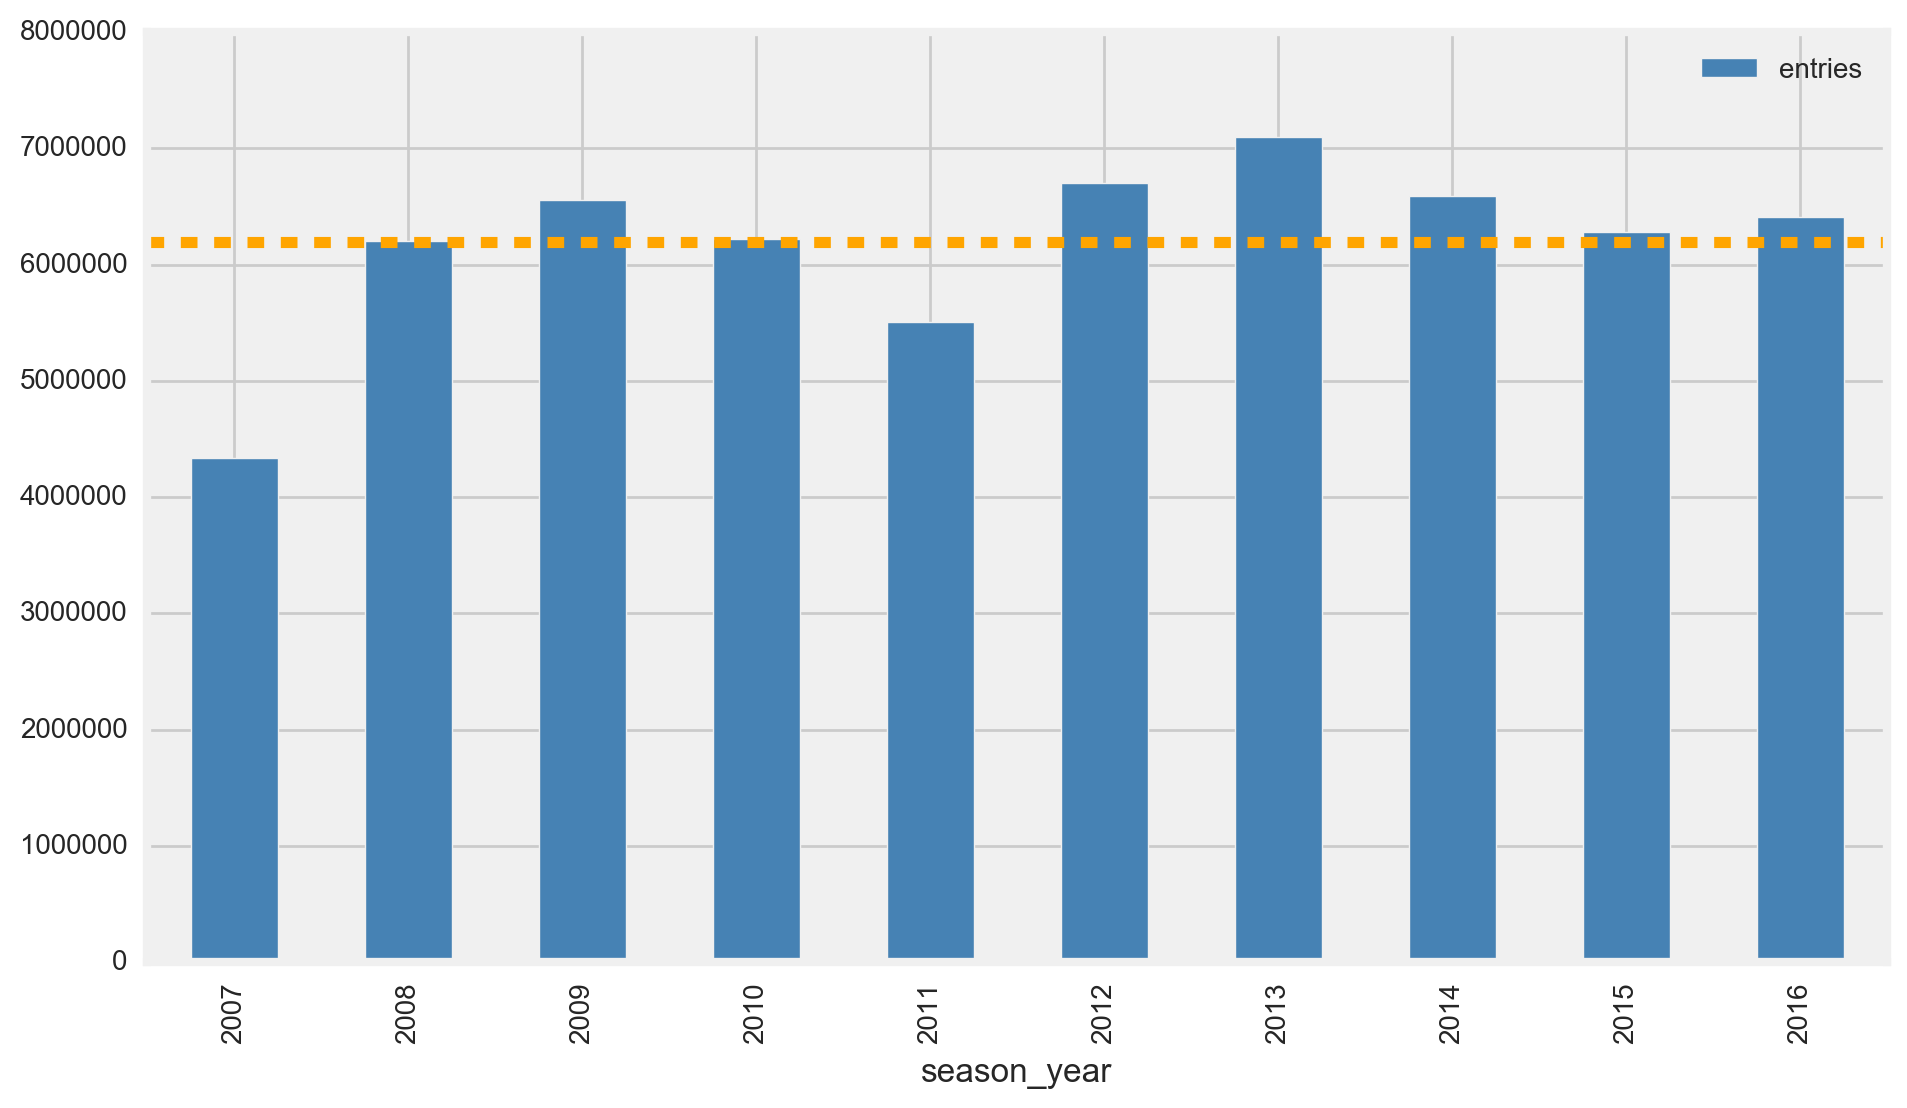

In [236]:
fig, ax = plt.subplots(figsize = (12,4))
ax = entries_per_year.plot(kind = 'bar', x = 'season_year', y = 'entries', figsize = (10,6), color = 'steelblue', ax = ax)
ax.axhline(y = entries_per_year.entries.mean(), ls = 'dashed', color = 'orange')

plt.show()

The yearly traffic has gradually increased over the years, with a drastic jump from 2007 to 2008 (+43%).
<ul>
--> Add the number of planes that landed over time<ul><ul>
--> Add the number of lifts that were in circulation<ul>


In [132]:
entries_per_day_of_week = df.groupby(['day_of_week'])[['entries']].sum().reset_index().sort_values(by = 'entries', ascending = False)
entries_per_day_of_week.head()

,day_of_week,entries
2,Saturday,9892536
5,Tuesday,9002265
6,Wednesday,8920714
4,Thursday,8838046
1,Monday,8705624


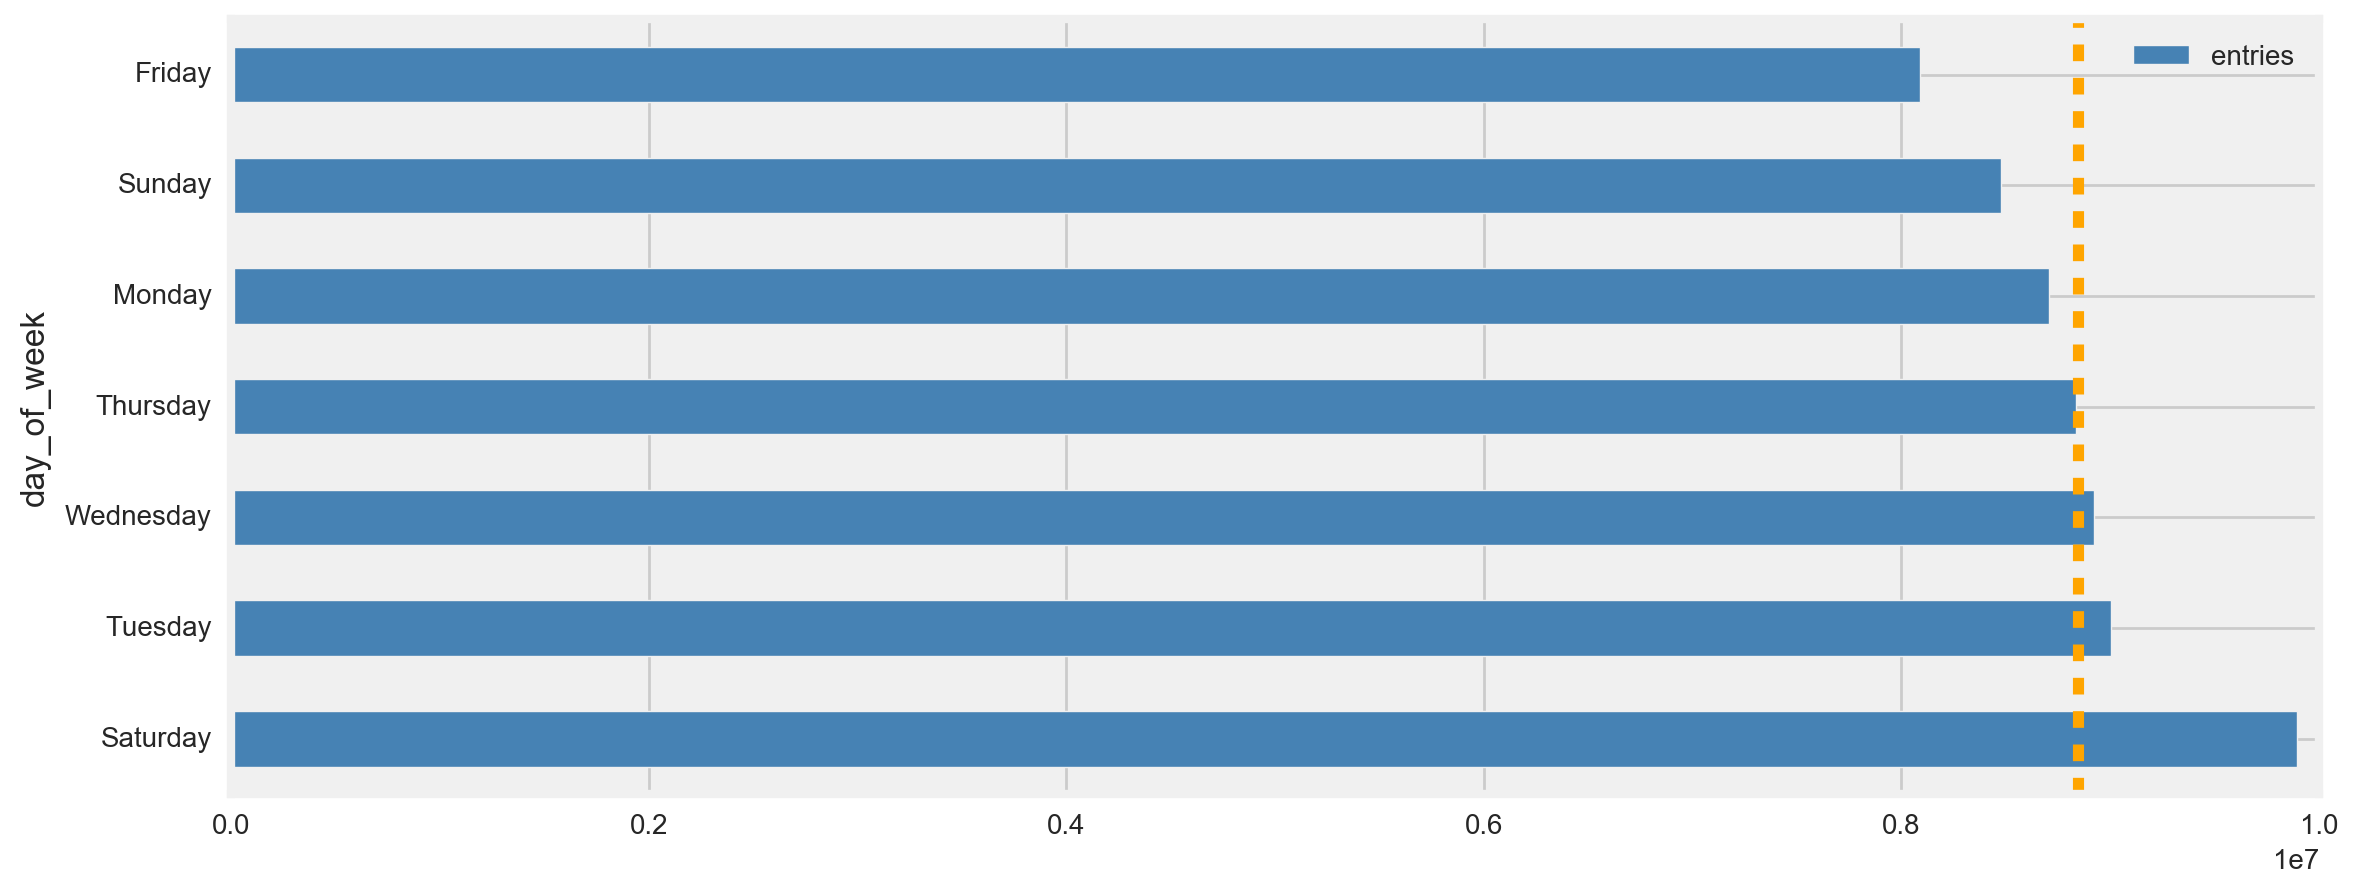

In [237]:
fig, ax = plt.subplots(figsize = (12,5))
ax = entries_per_day_of_week.plot(kind = 'barh', x = 'day_of_week', y = 'entries',color = 'steelblue', ax = ax)
ax.axvline(x = entries_per_day_of_week.entries.mean(), ls = 'dashed', color = 'orange')

plt.show()

People tend to ski a lot on Saturdays, as it's their last morning/day before leaving back to their hometown.<br>
Sundays are not so popular, as people just arrived for their weekholiday, and are just getting ready for their week (purchasing their skipass, getting their lodging...).<br>
The middle of the week tends to be pretty consistent in terms of traffic.

In [134]:
avg_entries_per_month = df.groupby(['season_month'])[['entries']].mean().reset_index()

In [135]:
avg_entries_per_month

,season_month,entries
0,1,51437
1,2,94894
2,3,61679


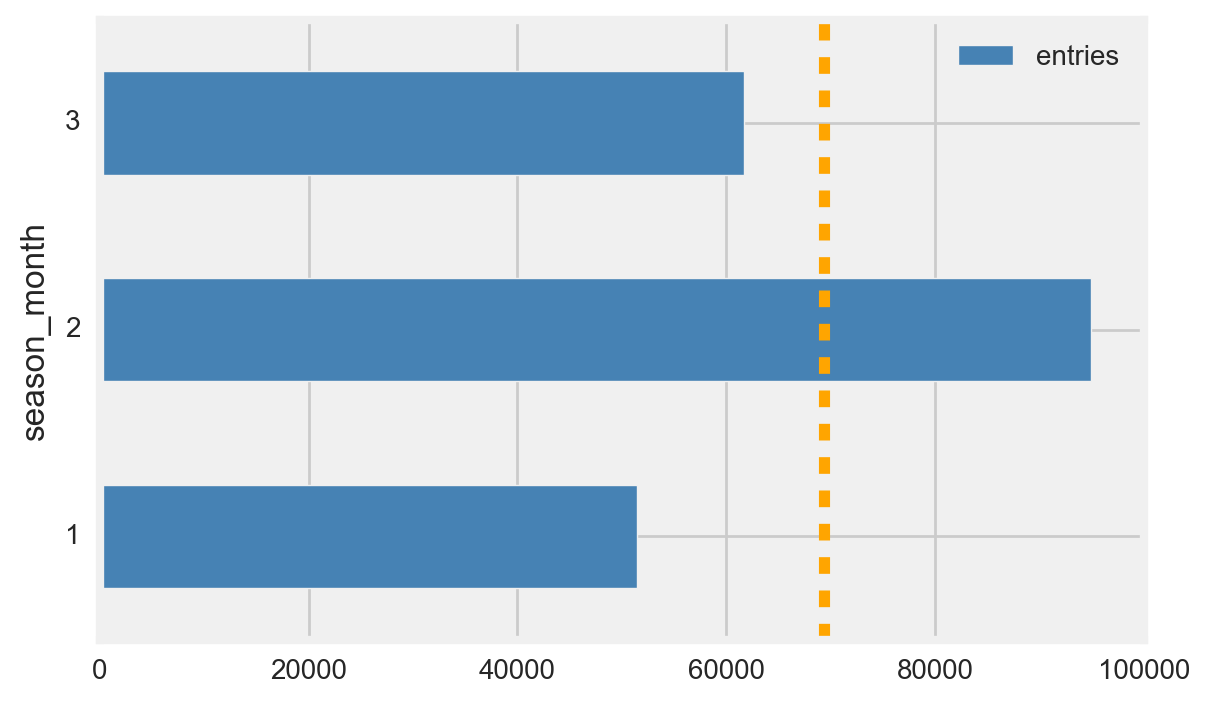

In [238]:
fig, ax = plt.subplots(figsize = (12,4))
ax = avg_entries_per_month.plot(kind = 'barh', x = 'season_month', y = 'entries',color = 'steelblue', figsize = (6,4), ax = ax)
ax.axvline(x = avg_entries_per_month.entries.mean(), ls = 'dashed', color = 'orange')

plt.show()

On average, traffic increases subsequently in February, as winter holidays happen everywhere in Europe.<br>
Also, heavier snowfalls tends to happend at that time, guaranteeing the skiers the highest number of open slopes.<br>
--> Add the snow levels to the graph.

In [139]:
# setting df.index as month/day
df.index = pd.to_datetime(df.date)
df.index = df.index.map(lambda val: val.strftime("%m/%d"))

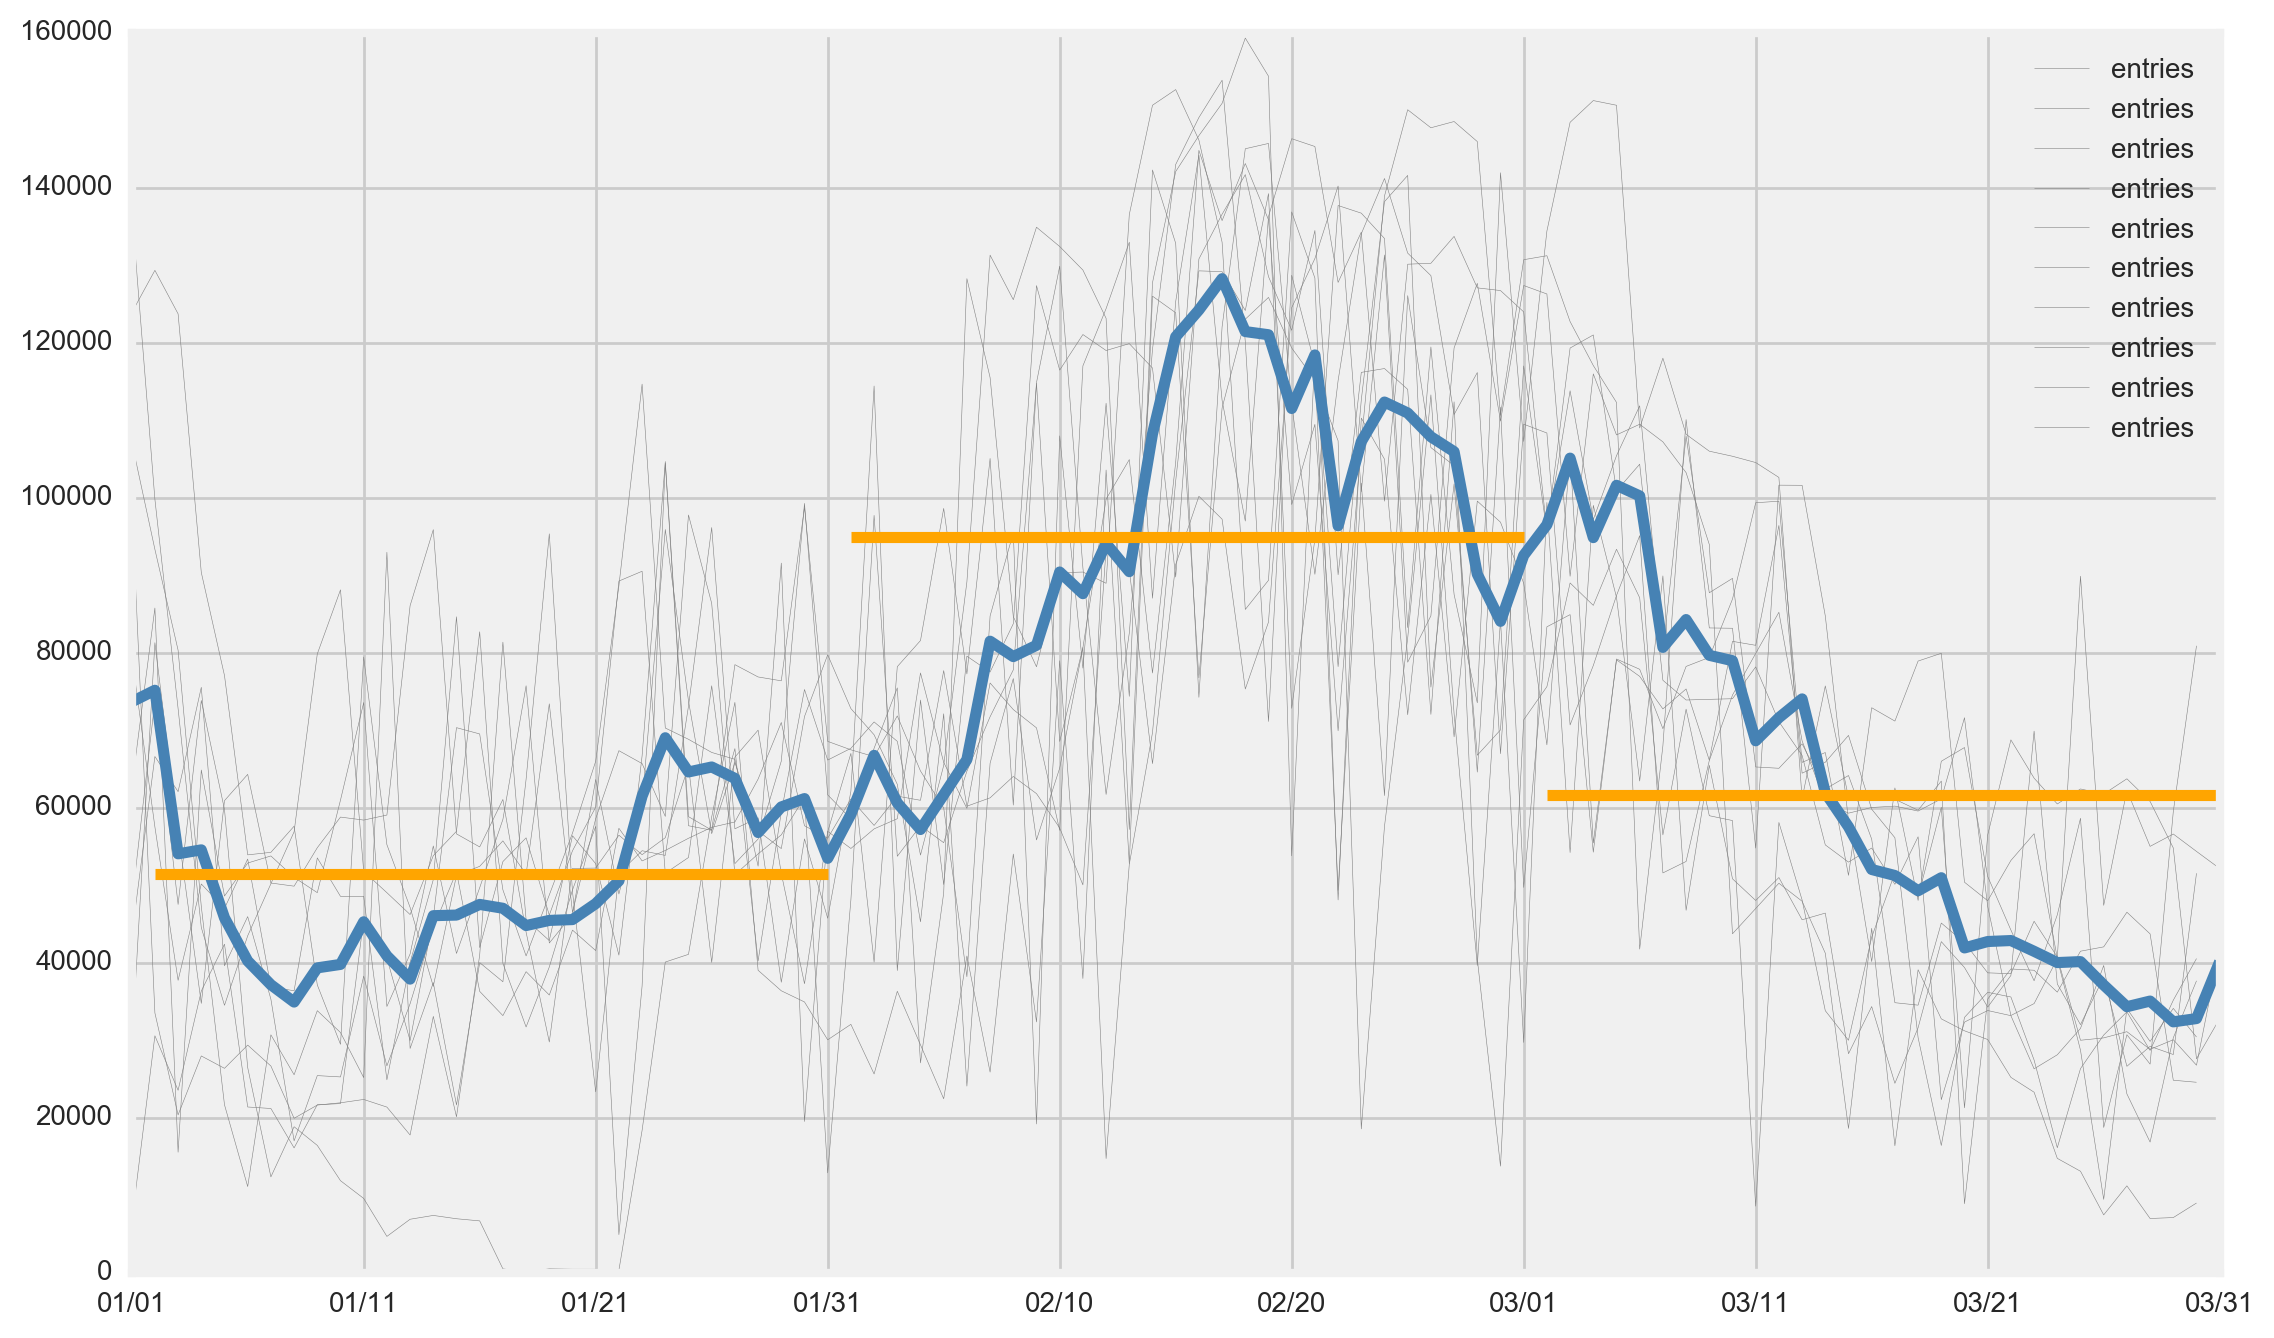

In [241]:
# setting up the chart
fig, ax = plt.subplots(figsize = (12,8))
years = df.season_year.unique().tolist()

# this for loop generates all the daily entries throughout a season, then plots them on the same graph
for season in years:
    ax = df[['date','entries']][df.season_year == season].plot(ax=ax, color = 'grey', linewidth = 0.2)

#ax = df[['date','entries']][df.season_year == 2016].plot(ax=ax, color = 'orange', linewidth = 1)

# this code plots the average daily entries throughout the seasons
ax = df.groupby(df.index)['entries'].mean().plot(ax = ax, color = 'steelblue')  

# retrieving and plotting the mean entries per month
mean_jan = df.entries[df.season_month == 1].mean()
mean_feb = df.entries[df.season_month == 2].mean()
mean_march = df.entries[df.season_month == 3].mean()
ax = plt.plot((1,30),(mean_jan,mean_jan), color = 'orange')
ax = plt.plot((31,60),(mean_feb,mean_feb), color = 'orange')
ax = plt.plot((61,90),(mean_march,mean_march), color = 'orange')

plt.show()

This graph shows the seasonal trend of entries.<br>
The green line shows the average amount of entries per day across all seasons; the grey lines represent the true values across all seasons.<br>
The dashed lines represent the average entries per month.<br>

-> Add the holidays periods on this graph.

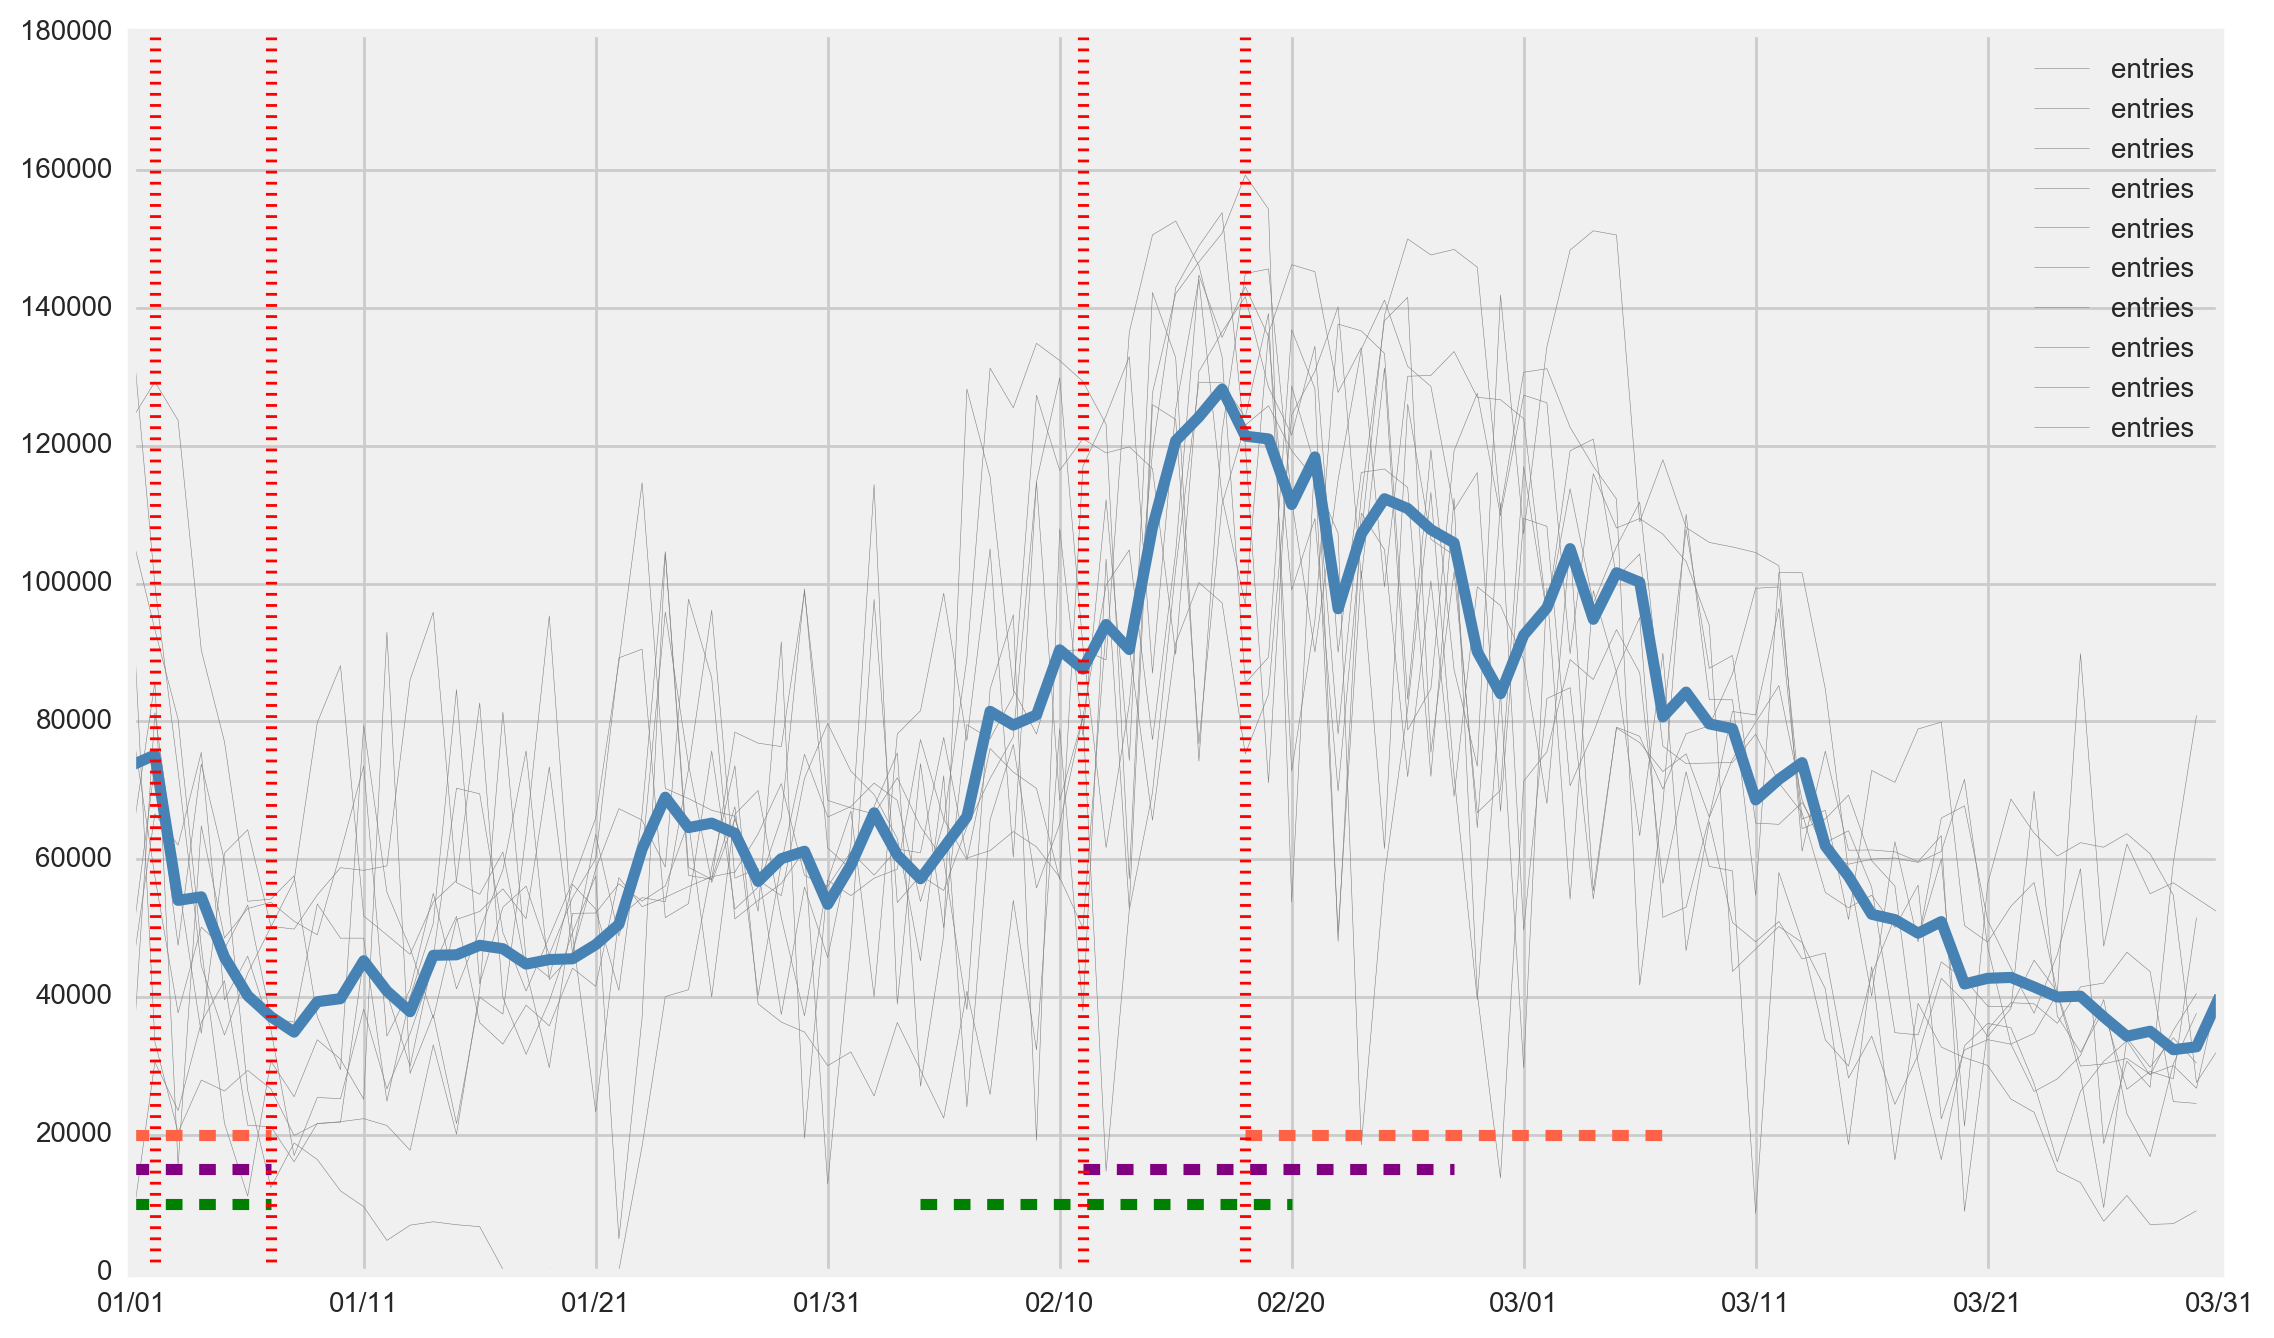

In [254]:
# setting up the chart
fig, ax = plt.subplots(figsize = (12,8))
years = df.season_year.unique().tolist()

# this for loop generates all the daily entries throughout a season, then plots them on the same graph
for season in years:
    df[['date','entries']][df.season_year == season].plot( color = 'grey', linewidth = 0.2, ax = ax)

#ax = df[['date','entries']][df.season_year == 2016].plot(ax=ax, color = 'orange', linewidth = 1)

# this code plots the average daily entries throughout the seasons
df.groupby(df.index)['entries'].mean().plot(ax = ax, color = 'steelblue')  

# plotting Xmas holidays for A,B and C french zones
ax = plt.plot((0,6),(20000,20000),linestyle = 'dashed', color = 'tomato')
ax = plt.plot((0,6),(15000,15000),linestyle = 'dashed', color = 'purple')
ax = plt.plot((0,6),(10000,10000),linestyle = 'dashed', color = 'green')

# plotting Winter holidays for A,B and C french zones
ax = plt.plot((48,66),(20000,20000),linestyle = 'dashed', color = 'tomato')
ax = plt.plot((41,57),(15000,15000),linestyle = 'dashed', color = 'purple')
ax = plt.plot((34,50),(10000,10000),linestyle = 'dashed', color = 'green')

# plotting 2 lines defining the common holidays for zones A,B and C
ax = plt.plot((1,1),(0,180000),linestyle = 'dotted', color = 'red')
ax = plt.plot((6,6),(0,180000),linestyle = 'dotted', color = 'red')
ax = plt.plot((41,41),(0,180000),linestyle = 'dotted', color = 'red')
ax = plt.plot((48,48),(0,180000),linestyle = 'dotted', color = 'red')

# Adding transparent rectangles
# see doc example here:
# https://github.com/stitchfix/Algorithms-Notebooks/blob/master/Long-Tails.ipynb

The graph above displays the schoolholidays for the 3 french zones.<br>
We clearly see that the highest periods are the ones where all 3 zones share some schoolholidays (between red vertical lines).<br>
It seems that zones A and B brings the most traffic to the resort.<br>
-> to be verified 

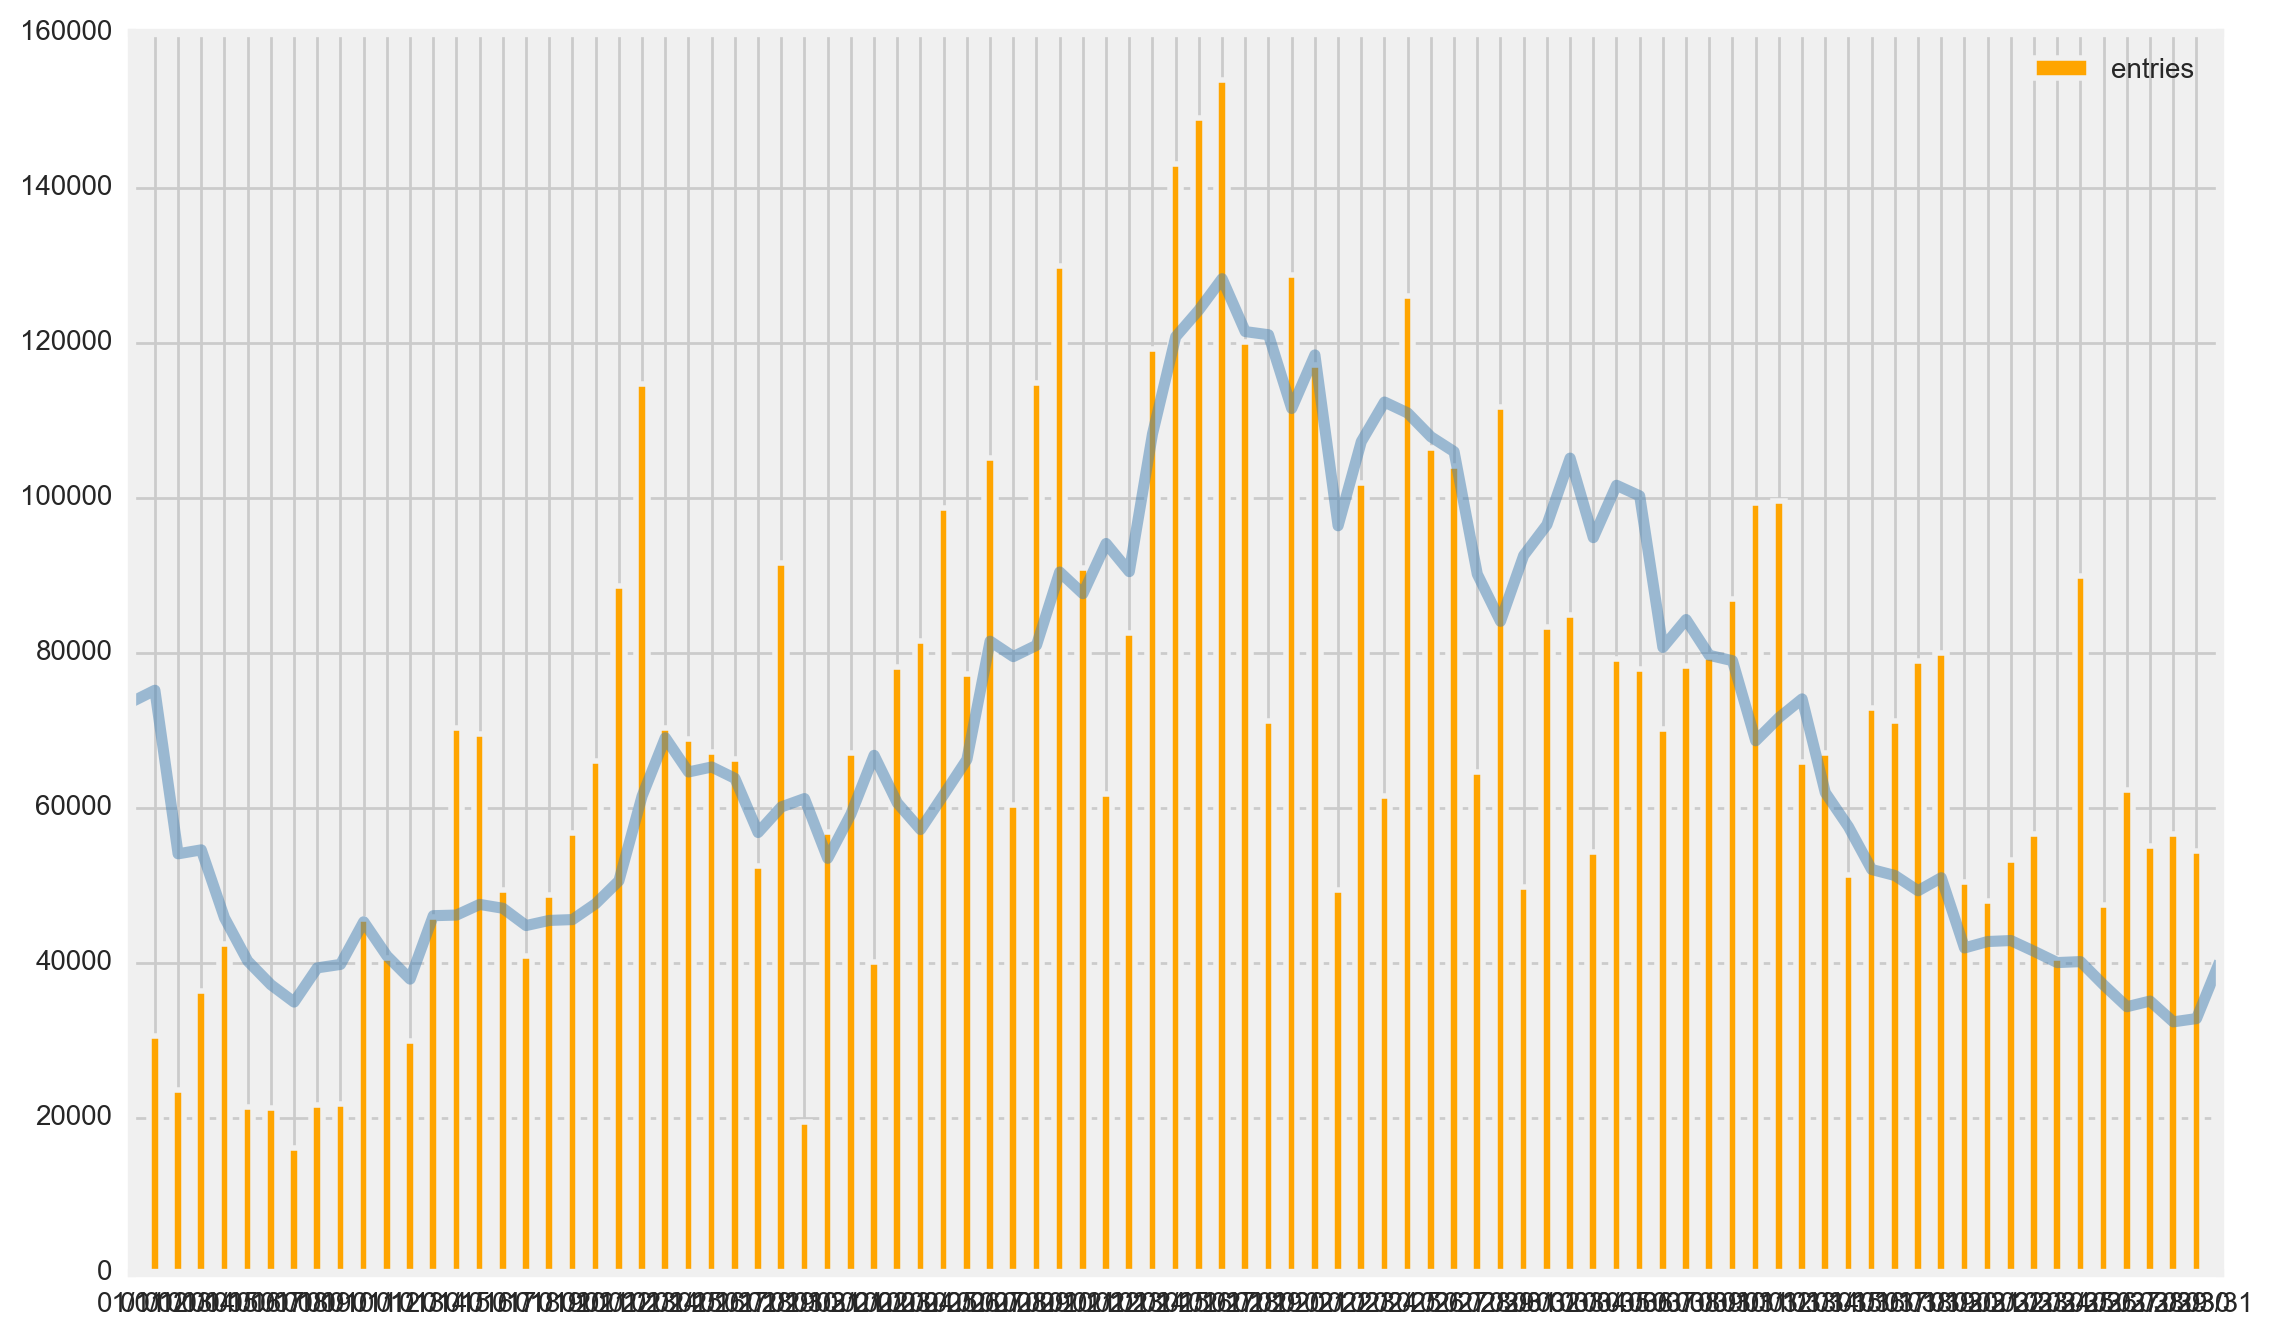

In [269]:
# setting up the chart
fig, ax = plt.subplots(figsize = (12,8))
years = df.season_year.unique().tolist()

# this for loop generates all the daily entries throughout a season, then plots them on the same graph
ax = df[['date','entries']][df.season_year == 2016].plot(ax=ax, color = 'orange', kind = 'bar', linewidth = 2)

# this code plots the average daily entries throughout the seasons
ax = df.groupby(df.index)['entries'].mean().plot(ax = ax, color = 'steelblue', alpha = 0.50)  

plt.show()

<p>From that point, we can compare the performances of any season over time, relative to the average.<br>
Above is the records of the last season, 2015/2016, in orange.<br>
It clearly indicates an early season below the average, but extremely good results in mid-Feb and end of March.<p>


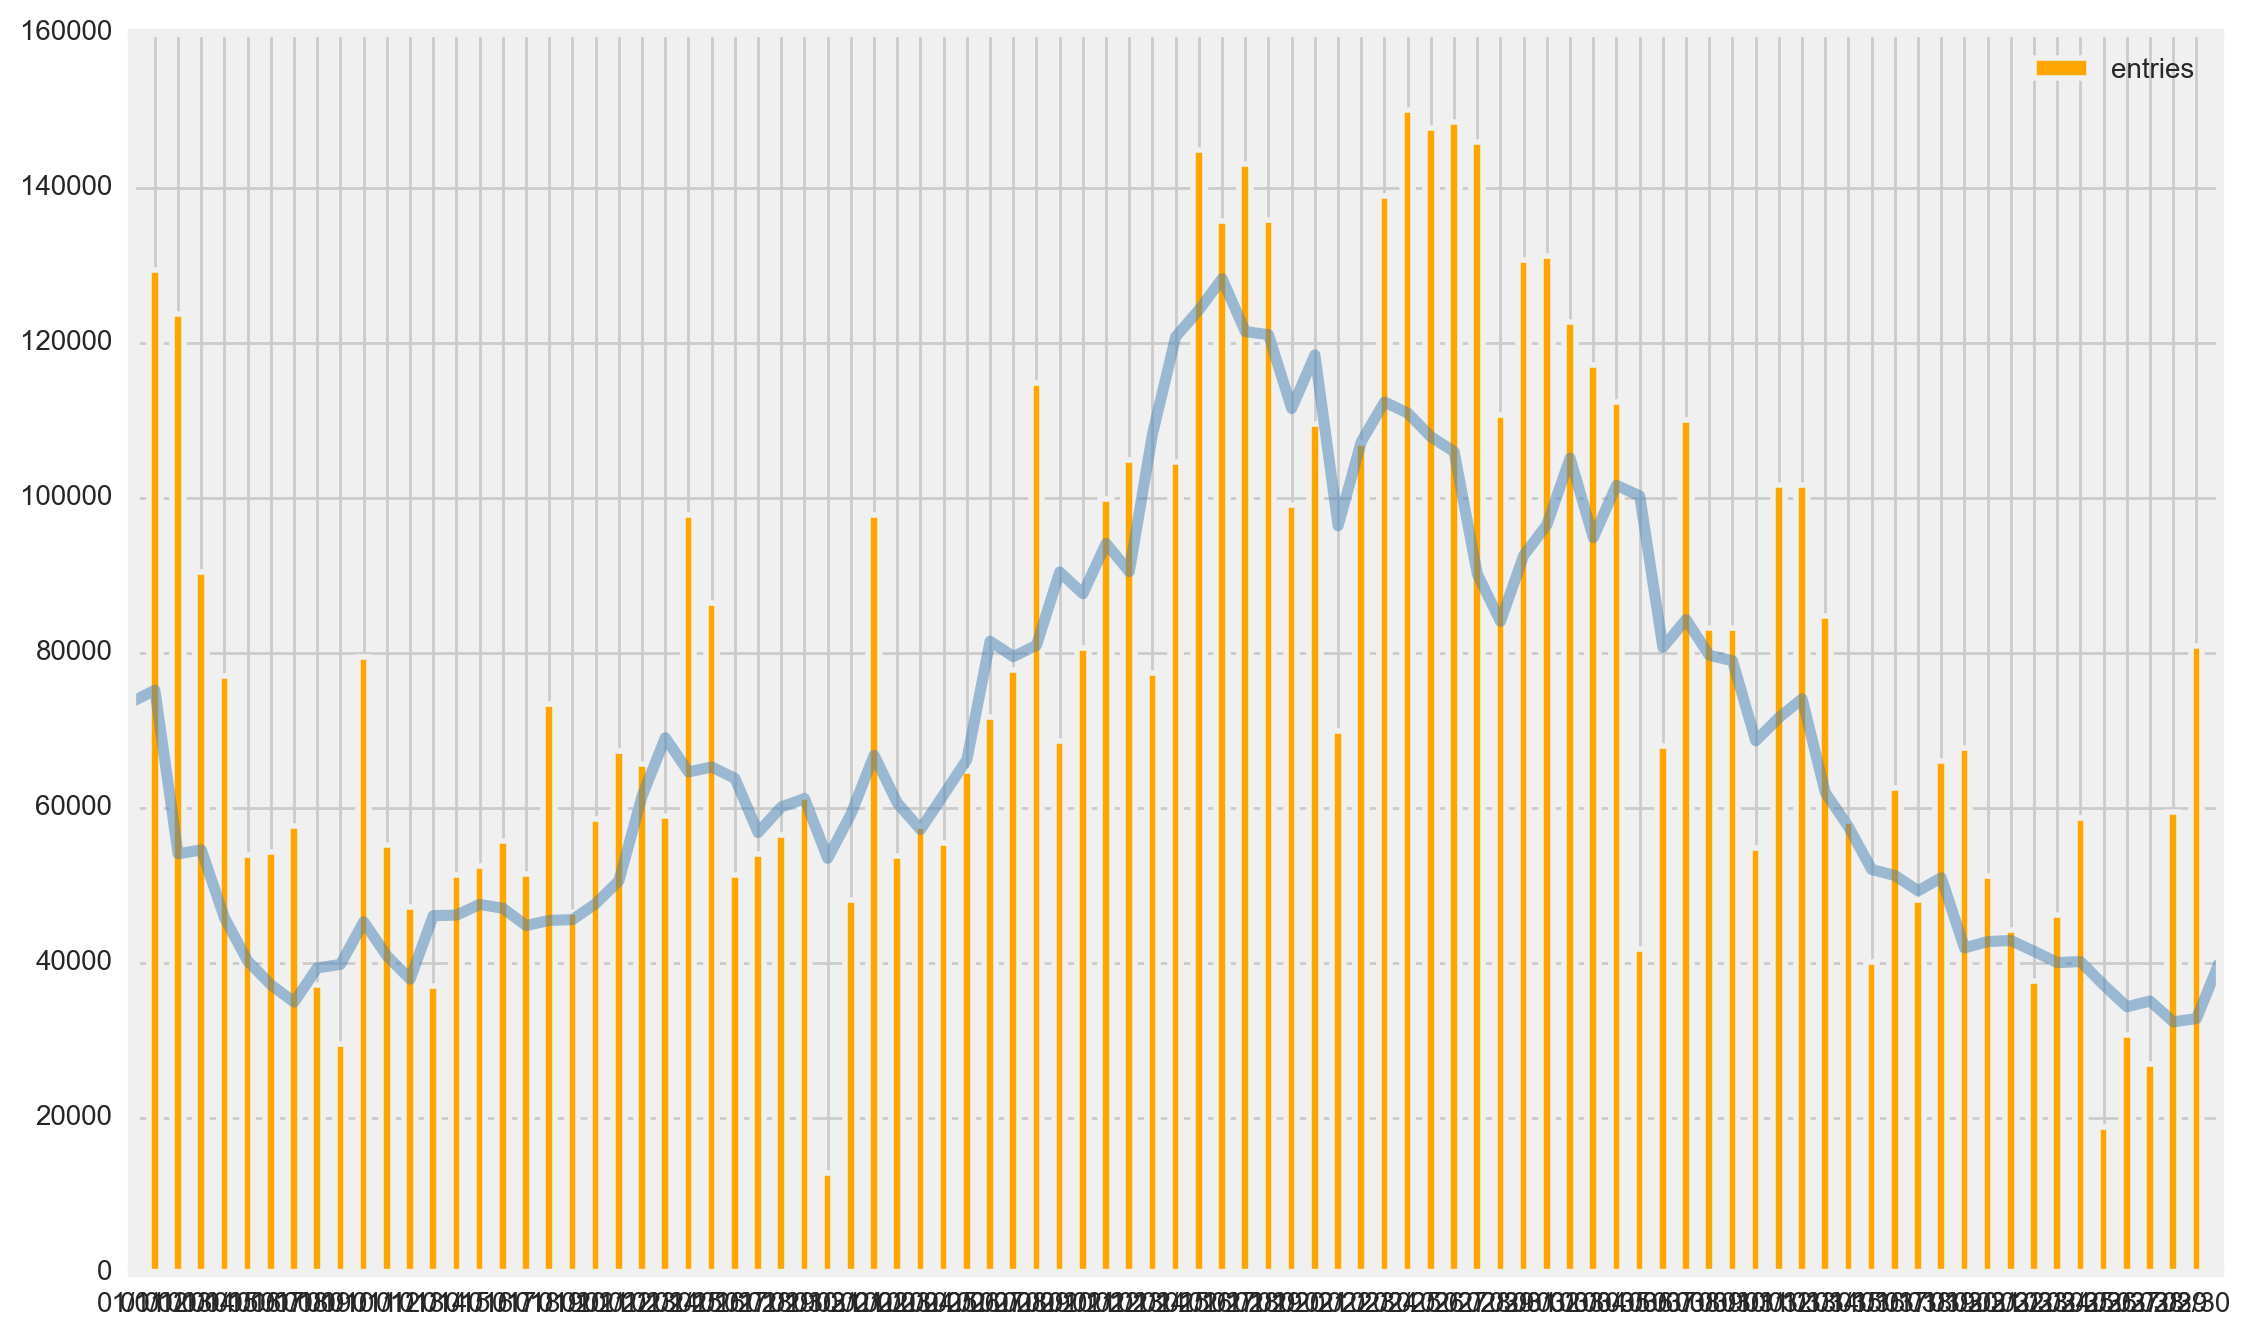

In [270]:
# setting up the chart
fig, ax = plt.subplots(figsize = (12,8))
years = df.season_year.unique().tolist()

# this for loop generates all the daily entries throughout a season, then plots them on the same graph
ax = df[['date','entries']][df.season_year == 2013].plot(ax=ax, color = 'orange', kind = 'bar', linewidth = 2)

# this code plots the average daily entries throughout the seasons
ax = df.groupby(df.index)['entries'].mean().plot(ax = ax, color = 'steelblue', alpha = 0.50)  

plt.show()

Above is the 2012-2013 season, which has been the best performing one of the last decade.<br>
Big gaps have been made in the early season (xmas holidays) and middle season (winter holidays).